# Train a Vision Transformer on small datasets

**Author:** [Aritra Roy Gosthipaty](https://twitter.com/ariG23498)<br>
**Date created:** 2022/01/07<br>
**Last modified:** 2022/01/10<br>
**Description:** Training a ViT from scratch on smaller datasets with shifted patch tokenization and locality self-attention.

## Introduction

In the academic paper
[An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale](https://arxiv.org/abs/2010.11929),
the authors mention that Vision Transformers (ViT) are data-hungry. Therefore,
pretraining a ViT on a large-sized dataset like JFT300M and fine-tuning
it on medium-sized datasets (like ImageNet) is the only way to beat
state-of-the-art Convolutional Neural Network models.

The self-attention layer of ViT lacks **locality inductive bias** (the notion that
image pixels are locally correlated and that their correlation maps are translation-invariant).
This is the reason why ViTs need more data. On the other hand, CNNs look at images through
spatial sliding windows, which helps them get better results with smaller datasets.

In the academic paper
[Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1),
the authors set out to tackle the problem of locality inductive bias in ViTs.

The main ideas are:

- **Shifted Patch Tokenization**
- **Locality Self Attention**

This example implements the ideas of the paper. A large part of this
example is inspired from
[Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).

_Note_: This example requires TensorFlow 2.6 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons), which can be
installed using the following command:

```python
pip install -qq -U tensorflow-addons
```

In [1]:
!pip install -qq -U tensorflow-addons
!pip install matplotlib
!pip install tensorflow==2.8
!pip install keras==2.8

## Setup

In [1]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

2022-08-30 18:56:37.155165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-30 18:56:37.155199: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Prepare the data

In [2]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

The hyperparameters are different from the paper. Feel free to tune
the hyperparameters yourself.

In [3]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 128

# AUGMENTATION
IMAGE_SIZE = 156
INPUT_SHAPE = (156,156,3)
PATCH_SIZE = 13
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 150

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

## Use data augmentation

A snippet from the paper:

*"According to DeiT, various techniques are required to effectively
train ViTs. Thus, we applied data augmentations such as CutMix, Mixup,
Auto Augment, Repeated Augment to all models."*

In this example, we will focus solely on the novelty of the approach
and not on reproducing the paper results. For this reason, we
don't use the mentioned data augmentation schemes. Please feel
free to add to or remove from the augmentation pipeline.

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2022-08-30 18:56:45.042659: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-30 18:56:45.042696: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 18:56:45.042720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-08-30 18:56:45.044893: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Implement Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are
then linearly projected into tokens. Shifted patch tokenization (STP)
is introduced to combat the low receptive field of ViTs. The steps
for Shifted Patch Tokenization are as follows:

- Start with an image.
- Shift the image in diagonal directions.
- Concat the diagonally shifted images with the original image.
- Extract patches of the concatenated images.
- Flatten the spatial dimension of all patches.
- Layer normalize the flattened patches and then project it.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [5]:

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        # define path levels
        self.patch_level_1 = 3
        self.patch_level_2 = 6
        self.patch_level_3 = 9
        
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, patch_level , images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = patch_level
            crop_width = patch_level
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = patch_level
            shift_height = patch_level
            shift_width = 0 

        elif mode == "right-up":
            crop_height = patch_level
            crop_width = 0
            shift_height = 0
            shift_width = patch_level
        else:
            crop_height = 0
            crop_width = 0
            shift_height = patch_level
            shift_width = patch_level

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - patch_level ,
            target_width=self.image_size - patch_level ,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad( self.patch_level_1 ,  images, mode="left-up"),
                    self.crop_shift_pad( self.patch_level_1 ,  images, mode="left-down"),
                    self.crop_shift_pad( self.patch_level_1 ,  images, mode="right-up"),
                    self.crop_shift_pad( self.patch_level_1 ,  images, mode="right-down"),
                    
                    self.crop_shift_pad( self.patch_level_2 ,  images, mode="left-up"),
                    self.crop_shift_pad( self.patch_level_2 ,  images, mode="left-down"),
                    self.crop_shift_pad( self.patch_level_2 ,  images, mode="right-up"),
                    self.crop_shift_pad( self.patch_level_2 ,  images, mode="right-down"),
                    
                    self.crop_shift_pad( self.patch_level_3 ,  images, mode="left-up"),
                    self.crop_shift_pad( self.patch_level_3 ,  images, mode="left-down"),
                    self.crop_shift_pad( self.patch_level_3 ,  images, mode="right-up"),
                    self.crop_shift_pad( self.patch_level_3 ,  images, mode="right-down"),
                    
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)


### Visualize the patches

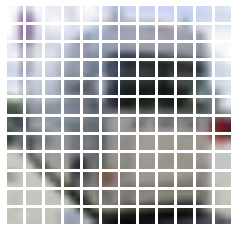

ORIGINAL


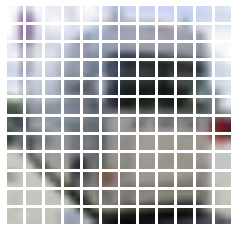

LEFT-UP 1


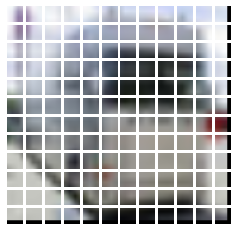

LEFT-DOWN 1


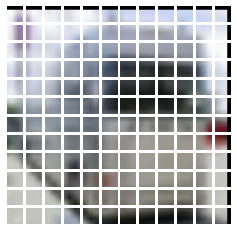

RIGHT-UP 1


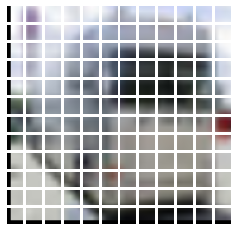

RIGHT-DOWN 1


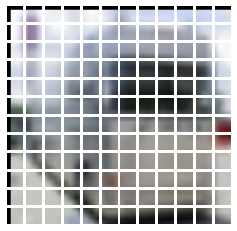

LEFT-UP 2


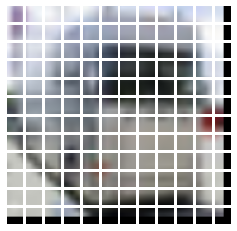

LEFT-DOWN 2


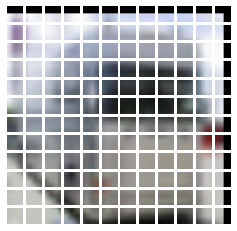

RIGHT-UP 2


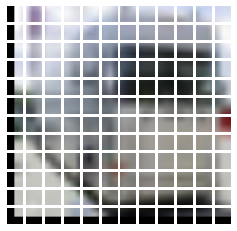

RIGHT-DOWN 2


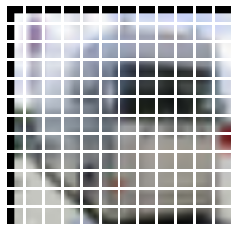

LEFT-UP 3


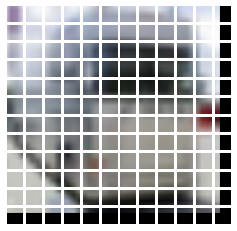

LEFT-DOWN 3


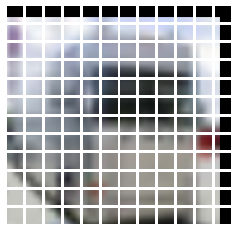

RIGHT-UP 3


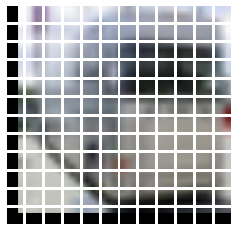

RIGHT-DOWN 3


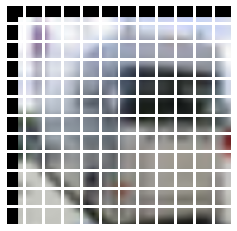

In [6]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]

shifted_images = [   "ORIGINAL", "LEFT-UP 1", "LEFT-DOWN 1", "RIGHT-UP 1" ,  "RIGHT-DOWN 1" , 
                     "LEFT-UP 2", "LEFT-DOWN 2", "RIGHT-UP 2" ,  "RIGHT-DOWN 2" , 
                     "LEFT-UP 3", "LEFT-DOWN 3", "RIGHT-UP 3" ,  "RIGHT-DOWN 3"  
                 ]

for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 13 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## Implement the patch encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [7]:

class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches


## Implement Locality Self Attention

The regular attention equation is stated below.

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

The attention module takes a query, key, and value. First, we compute the
similarity between the query and key via a dot product. Then, the result
is scaled by the square root of the key dimension. The scaling prevents
the softmax function from having an overly small gradient. Softmax is then
applied to the scaled dot product to produce the attention weights.
The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input.
The dot product would result in large self-token relations rather than
inter-token relations. This also means that the softmax gives higher
probabilities to self-token relations than the inter-token relations.
To combat this, the authors propose masking the diagonal of the dot product.
This way, we force the attention module to pay more attention to the
inter-token relations.

The scaling factor is a constant in the regular attention module.
This acts like a temperature term that can modulate the softmax function.
The authors suggest a learnable temperature term instead of a constant.

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |

The above two pointers make the Locality Self Attention. We have subclassed the
[`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
and implemented the trainable temperature. The attention mask is built
at a later stage.

In [8]:

class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores


## Implement the MLP

In [9]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## Build the ViT

In [10]:

def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape= (32,32,3) )
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## Compile, train, and evaluate the mode

In [12]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

## model training

In [13]:
total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.10
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
)

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
)

vit_sl = create_vit_classifier(vanilla=False)
vit_sl.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)

history = vit_sl.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
)
_, accuracy, top_5_accuracy = vit_sl.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

Epoch 1/150
  2/352 [..............................] - ETA: 1:03:00 - loss: 7.6921 - accuracy: 0.0156 - top-5-accuracy: 0.0469

KeyboardInterrupt: 

## print prediction stats

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
#sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix , classification_report

def print_info( preds , targets  ):
    class_dict= target_dict 
    labels= targets

    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}

    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    
    df_list = []
    
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)        
        true_index=labels[i][0]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred

            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            
        y_pred.append(pred_index)    
        
        i_sample ={
            "prediction": new_dict[ pred_index ] ,
            "gt" : new_dict[ true_index ]
        }
        
        df_list.append( i_sample )

    if len(classes)<= 80:
        # create a confusion matrix and a test report        
        y_true= np.array(labels)        
        y_pred=np.array(y_pred)        
        cm = confusion_matrix(y_true, y_pred )
        clr = classification_report(y_true, y_pred, target_names=classes , zero_division=0)
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()    
        print("Classification Report:\n----------------------\n", clr)
        
    # generate the prediction dataframe
    df_ = pd.DataFrame( df_list )
    df_.to_csv("predictions.csv")

> geenerate predictions and stats

In [15]:
preds= vit_sl.predict( x_test ) 
print_info( preds , y_test ) 

KeyboardInterrupt: 